<a href="https://colab.research.google.com/github/YairYarden/DeepCascadingAMC/blob/feature%2Fnew_code_using_classes/Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [13]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Chose Device

In [14]:
# check if CUDA is available
import torch
is_gpu_available = torch.cuda.is_available()

if not is_gpu_available:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

CUDA is available!  Training on GPU ...


# Load Python Files

In [15]:
# Load files 
from google.colab import files

# Dataset Classes
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/encoder.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/dataset.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/dataset_builder.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/rml_2016.py /content

# Utils Classes
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/utils/plot.py /content

# Training Classes
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/training/accuracy.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/training/confusion.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/training/baseModel.py /content



# Import Functions & Classes

In [18]:
# Plotting Includes
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# External Includes
import numpy as np
from pprint import pprint

from torch.autograd import Variable
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

# Internal Includes
# Data
from dataset import Dataset
from encoder import Encoder
from rml_2016 import load_RML201610B_dataset

# Utils
from plot import plot_acc_vs_snr, plot_confusion, plot_convergence, plot_IQ

# Training
from accuracy import compute_accuracy, compute_accuracy_on_cross_sections
from confusion import compute_confusion
from baseModel import Model

# Load Dataset

## Load 

In [19]:
# Load
import os
drive_path = '/content/drive/MyDrive/Deep_learning_05107255/project'
data_path = os.path.join(drive_path, 'RadioML2016_b/RML2016.10b.dat')
dataset = load_RML201610B_dataset(path=data_path)

# Print
print(len(dataset))
pprint(dataset.get_examples_per_class())

1200000
{'8PSK': 120000,
 'AM-DSB': 120000,
 'BPSK': 120000,
 'CPFSK': 120000,
 'GFSK': 120000,
 'PAM4': 120000,
 'QAM16': 120000,
 'QAM64': 120000,
 'QPSK': 120000,
 'WBFM': 120000}


## Split to Train - Val - Test

In [20]:
train, test = dataset.split(frac=0.3, on=["Modulation", "SNR"])
train, val = train.split(frac=0.05, on=["Modulation", "SNR"])

print("Training Examples")
print("=================")
pprint(train.get_examples_per_class())
print("=================")
print()
print("Validation Examples")
print("=================")
pprint(val.get_examples_per_class())
print("=================")
print()
print("Testing Examples")
print("=================")
pprint(test.get_examples_per_class())
print("=================")

Training Examples
{'8PSK': 79780,
 'AM-DSB': 79780,
 'BPSK': 79780,
 'CPFSK': 79780,
 'GFSK': 79780,
 'PAM4': 79780,
 'QAM16': 79780,
 'QAM64': 79780,
 'QPSK': 79780,
 'WBFM': 79780}

Validation Examples
{'8PSK': 4200,
 'AM-DSB': 4200,
 'BPSK': 4200,
 'CPFSK': 4200,
 'GFSK': 4200,
 'PAM4': 4200,
 'QAM16': 4200,
 'QAM64': 4200,
 'QPSK': 4200,
 'WBFM': 4200}

Testing Examples
{'8PSK': 36020,
 'AM-DSB': 36020,
 'BPSK': 36020,
 'CPFSK': 36020,
 'GFSK': 36020,
 'PAM4': 36020,
 'QAM16': 36020,
 'QAM64': 36020,
 'QPSK': 36020,
 'WBFM': 36020}


## Labels encoder

In [21]:
le = Encoder(["WBFM",
              "AM-DSB",
              "AM-SSB",
              "CPFSK",
              "GFSK",
              "BPSK",
              "QPSK",
              "8PSK",
              "PAM4",
              "QAM16",
              "QAM64"],
             label_name="Modulation")
print(le)

WBFM: 0
AM-DSB: 1
AM-SSB: 2
CPFSK: 3
GFSK: 4
BPSK: 5
QPSK: 6
8PSK: 7
PAM4: 8
QAM16: 9
QAM64: 10



## Plot Example

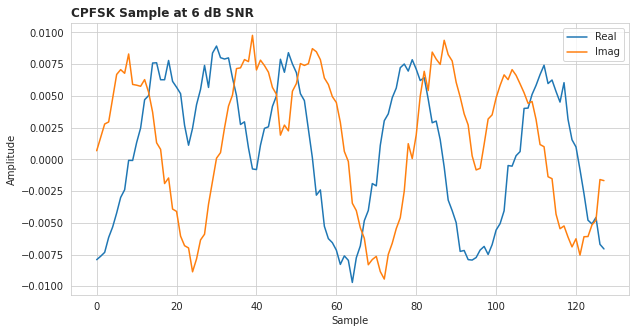

In [22]:
fig_dir = None
# Plot a sample of the data
# You can choose a different sample by changing
idx = 10
snr = 6.0
modulation = "CPFSK"

mask = (dataset.df["SNR"] == snr) & (dataset.df["Modulation"] == modulation)
sample = dataset.as_numpy(mask=mask, le=le)[0][idx,0,:]
t = np.arange(sample.shape[1])

title = "{modulation} Sample at {snr:.0f} dB SNR".format(modulation=modulation, snr=snr)
fig = plot_IQ(iq=sample, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/{modulation}_{snr:.0f}dB_sample.pdf".format(fig_dir=fig_dir,
                                                                       modulation=modulation,
                                                                       snr=snr)
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

# Model

In [23]:
class MyCNN(Model):
    def __init__(self, input_samples: int, n_classes: int):
        super().__init__(input_samples=input_samples, n_classes=n_classes)
        # Batch x 1-channel x IQ x input_samples
        # Modifying the first convolutional layer to not use a bias term is a
        # modification made by Bryse Flowers due to the observation of vanishing
        # gradients during training when ported to PyTorch (other authors used
        # Keras).
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=256,
            kernel_size=(1, 7),
            padding=(0, 3),
            bias=False,
        )
        self.a1 = nn.ReLU()
        self.n1 = nn.BatchNorm2d(256)

        self.conv2 = nn.Conv2d(
            in_channels=256,
            out_channels=80,
            kernel_size=(2, 7),
            padding=(0, 3),
            bias=True,
        )
        self.a2 = nn.ReLU()
        self.n2 = nn.BatchNorm2d(80)

        # Batch x Features
        self.dense1 = nn.Linear(80 * 1 * input_samples, 256)
        self.a3 = nn.ReLU()
        self.n3 = nn.BatchNorm1d(256)

        self.dense2 = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.a1(x)
        x = self.n1(x)

        x = self.conv2(x)
        x = self.a2(x)
        x = self.n2(x)

        # Flatten the input layer down to 1-d by using Tensor operations
        x = x.contiguous()
        x = x.view(x.size()[0], -1)

        x = self.dense1(x)
        x = self.a3(x)
        x = self.n3(x)

        x = self.dense2(x)

        return x

model = MyCNN(input_samples=128, n_classes=11)
print(model)       

MyCNN(
  (conv1): Conv2d(1, 256, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3), bias=False)
  (a1): ReLU()
  (n1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 80, kernel_size=(2, 7), stride=(1, 1), padding=(0, 3))
  (a2): ReLU()
  (n2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=10240, out_features=256, bias=True)
  (a3): ReLU()
  (n3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=256, out_features=11, bias=True)
)
----------------------
Trainable Parameters: 2914299
Fixed Parameters: 0
Total Parameters: 2914299
----------------------



# Training Functions

In [24]:
class MyTrainingStrategy(object):

    def __init__(self, lr: float = 10e-4, n_epochs: int = 3, gpu: bool = True):
        self.lr = lr
        self.n_epochs = n_epochs
        self.gpu = gpu

    def __repr__(self):
        ret = self.__class__.__name__
        ret += "(lr={}, n_epochs={}, gpu={})".format(self.lr, self.n_epochs, self.gpu)
        return ret
        
    def __call__(
        self, model: nn.Module, training: Dataset, validation: Dataset, le: Encoder
    ):
        criterion = nn.CrossEntropyLoss()

        if self.gpu:
            model.cuda()
            criterion.cuda()

        optimizer = Adam(model.parameters(), lr=self.lr)

        train_data = DataLoader(
            training.as_torch(le=le), shuffle=True, batch_size=512
        )
        val_data = DataLoader(
            validation.as_torch(le=le), shuffle=True, batch_size=512
        )

        # Save two lists for plotting a convergence graph at the end
        ret_train_loss = list()
        ret_val_loss = list()
        
        for epoch in range(self.n_epochs):
            model, train_loss = self._train_one_epoch(model=model, data=train_data, loss_fn=criterion, optimizer=optimizer)

            print("On Epoch {} the training loss was {}".format(epoch, train_loss))
            ret_train_loss.append(train_loss)

            val_loss = self._validate_once(
                model=model, data=val_data, loss_fn=criterion
            )
            print("---- validation loss was {}".format(val_loss))
            ret_val_loss.append(val_loss)

        return model, ret_train_loss, ret_val_loss

    def _train_one_epoch(
        self, model: nn.Module, data: DataLoader, loss_fn: nn.CrossEntropyLoss, optimizer: Adam
    ) -> float:
        total_loss = 0.0
        # Switch the model mode so it remembers gradients, induces dropout, etc.
        model.train()

        for i, batch in enumerate(data):
            x, y = batch

            # Push data to GPU if necessary
            if self.gpu:
                x = Variable(x.cuda())
                y = Variable(y.cuda())
            else:
                x = Variable(x)
                y = Variable(y)

            # Forward pass of prediction
            outputs = model(x)

            # Zero out the parameter gradients, because they are cumulative,
            # compute loss, compute gradients (backward), update weights
            loss = loss_fn(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        mean_loss = total_loss / (i + 1.0)
        return model, mean_loss

    def _validate_once(
        self, model: nn.Module, data: DataLoader, loss_fn: nn.CrossEntropyLoss
    ) -> float:
        total_loss = 0.0
        # Switch the model back to test mode (so that batch norm/dropout doesn't
        # take effect)
        model.eval()
        for i, batch in enumerate(data):
            x, y = batch

            if self.gpu:
                x = x.cuda()
                y = y.cuda()

            outputs = model(x)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

        mean_loss = total_loss / (i + 1.0)
        return mean_loss

In [25]:
gpu = is_gpu_available
trainer = MyTrainingStrategy(gpu=gpu)
print(trainer)

MyTrainingStrategy(lr=0.001, n_epochs=3, gpu=True)


# Train the network

In [26]:
model, train_loss, val_loss = trainer(model=model, training=train, validation=val, le=le)

On Epoch 0 the training loss was 1.100427273491241
---- validation loss was 1.013316604028265
On Epoch 1 the training loss was 0.9966201913746754
---- validation loss was 0.9892641837338367
On Epoch 2 the training loss was 0.9604937602037646
---- validation loss was 0.9914512454745281


## Plot results

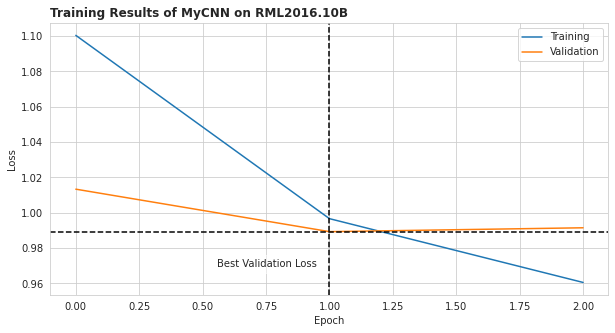

In [27]:
title = "Training Results of {model_name} on {dataset_name}".format(model_name="MyCNN", dataset_name="RML2016.10B")
fig = plot_convergence(train_loss=train_loss, val_loss=val_loss, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/training_loss.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

# Save Model

In [28]:
from datetime import datetime 

def save_model(model, dir_path, name):
  # create checkpints folder
  checkpoint_folder = os.path.join(dir_path, 'checkpoints')
  os.makedirs(checkpoint_folder, exist_ok=True)
  # save model
  curr_datetime = datetime.now().strftime("%y_%m_%d_%H:%M:%S")
  model_name = f'{curr_datetime}'.replace(':', '_')
  model_name = name + '_' + model_name
  
  ckpt_path = os.path.join(checkpoint_folder, f'{model_name}.ckpt')
  torch.save({
    'model_state_dict': model.state_dict(),
  }, ckpt_path)

  print(f'model saved to "{ckpt_path}"')

save_model(model, drive_path, 'basic_amc')


model saved to "/content/drive/MyDrive/Deep_learning_05107255/project/checkpoints/basic_amc_22_07_18_18_47_32.ckpt"


# Test

## Overall Accuracy

In [29]:
acc = compute_accuracy(model=model, data=test, le=le)
print("Overall Testing Accuracy: {:.4f}".format(acc))

Overall Testing Accuracy: 0.5874


## Accuracy vs SNR

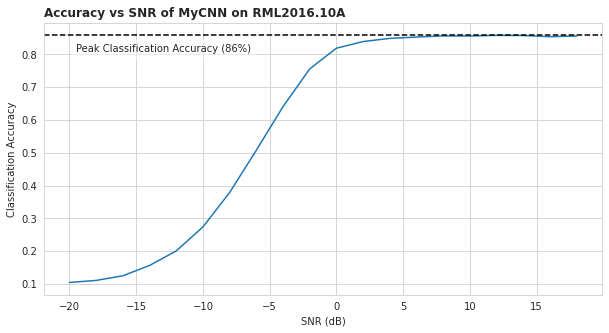

In [30]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model,
                                                     data=test,
                                                     le=le,
                                                     column="SNR")

title = "Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="MyCNN", dataset_name="RML2016.10A")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/acc_vs_snr.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

## Confusion matrix

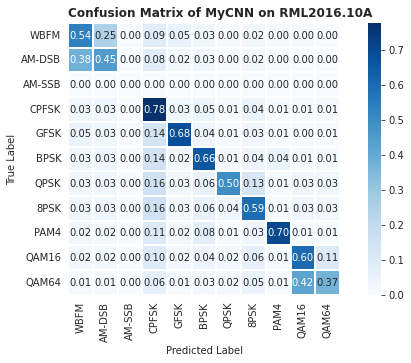

In [31]:
cmn = compute_confusion(model=model, data=test, le=le)

title = "Confusion Matrix of {model_name} on {dataset_name}".format(model_name="MyCNN", dataset_name="RML2016.10A")
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()